# Only Parallel Data Model

This is the Python Notebook concerning the final version containing the coding for the Only-Parallel (Supervised) version of the program. It is to be completed with the correct format of the Contextual and Style Classifiers in their corresponding parts.

Date of upload: Friday 31th January

Actual Version: 2.0, running with style_class (Sunday 9th February)

Precedent Versions : 1.1, 1.0



## import(s)

In [3]:
from scripts.data_builders.prepare_dataset import prepare_dataset,string2code,code2string

import math
import torch
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device = ",device)

device =  cpu


## Data Pre-processing

In [4]:
train_data, dict_words = prepare_dataset("data/shakespeare.csv",device,ratio=0.5,shuffle_ctx=False) #check with shift+tab to look at the data structure
batch_size = 64
dict_token = {b:a for a,b in dict_words.items()}

Loading ...
- Shakespeare dataset length :  21079
- Corrupted samples (ignored) :  0


## Parameters and Embedding

In [5]:
class State:
    def __init__(self,model,optim):
        self.model = model
        self.optim = optim
        self.epoch = 0
savepath = Path("data/models/embeddings/v0")
embedding = torch.load(savepath).to(device)
embedding.weight.requires_grad = False #Embedding freeze

In [6]:
nb_heads = 4
d_feedforward = 1024
batch_size = 64
dict_size = len(dict_token)

d_embedding = embedding.embedding_dim

## Positional Encoding

In [7]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Context Classifier (To be filled)

## Style classifier (To be filled)

In [8]:
class Transpose(torch.nn.Module):
    def __init__(self,dim0,dim1):
        super().__init__()
        self.dim0=dim0
        self.dim1=dim1

    def forward(self,x):
        return torch.transpose(x,dim0=self.dim0,dim1=self.dim1)

class Reduce(torch.nn.Module):
    def __init__(self,dim):
        super().__init__()
        self.dim=dim

    def forward(self,x):
        x=torch.sum(x,dim=self.dim)
        return x.reshape(x.shape[0],x.shape[1])

class StyleClassifier(torch.nn.Module):
    def __init__(self,dict_size=18000,d_embedding=300,d_hidden=10):
        super(StyleClassifier,self).__init__()
        self.embedding=nn.Embedding(dict_size+1,d_embedding,padding_idx=dict_size)
        self.transpose=Transpose(1,2)
        self.conv1d=nn.Conv1d(d_embedding,d_hidden,3,1)
        self.reduce=Reduce(2)
        self.pool=nn.MaxPool1d(3,1)
        self.linear=nn.Linear(d_hidden,1)
        self.sigmoid=nn.Sigmoid()
        self.model=nn.Sequential(
            self.embedding,
            self.transpose,
            self.conv1d,
            self.pool,
            self.reduce,
            self.linear,
            self.sigmoid)
        
    def forward(self,x):
        return self.model(x)
        
        
savepath_style = Path("data/models/style_classifier_v0")
style_classifier = torch.load(savepath_style).model.to(device)
style_classifier.requires_grad = False

## Model (To be adapted once we have the Context and Style Class For the Embedding)

In [9]:
class ParallelModel(torch.nn.Module):
    def __init__(self,dict_size, d_embedding, nb_heads, d_feedforward):
        super().__init__()
        
        self.embed_layer = torch.nn.Embedding(dict_size+1, d_embedding, padding_idx=dict_size)
        self.positional_layer = PositionalEncoding(d_embedding)
        self.sentence_encoder = torch.nn.TransformerEncoderLayer(d_model = d_embedding, nhead = nb_heads, 
                                                    dim_feedforward = d_feedforward)
        self.context_encoder = torch.nn.TransformerEncoderLayer(d_model = d_embedding, nhead = nb_heads, 
                                                    dim_feedforward = d_feedforward)
        self.sentence_decoder = torch.nn.TransformerDecoderLayer(d_model = d_embedding, nhead = nb_heads, 
                                                    dim_feedforward = d_feedforward)
        self.label_embedding = torch.nn.Embedding(2,768)
    
    
    def _generate_square_subsequent_mask(self,sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def forward(self,x,ctx_x,y,label_x):
        device = x.device
        mask_x = self._generate_square_subsequent_mask(x.shape[1]).to(device)
        mask_ctx = self._generate_square_subsequent_mask(ctx_x.shape[1]).to(device)
        mask_y = self._generate_square_subsequent_mask(y.shape[1]).to(device)
        
        # Embedding
        x = self.embed_layer(x).transpose(0,1) # token x batch x embedding
        ctx_x = self.embed_layer(ctx_x).transpose(0,1)
        
        # Positional Encoding
        x = self.positional_layer(x)
        ctx_x = self.positional_layer(ctx_x)        
        
        # Encoders
        x_enc = self.sentence_encoder(x,mask_x)
        ctx_enc = self.context_encoder(ctx_x,mask_ctx)

        # Linear and Style Mixing
        x_and_ctx = torch.cat((x_enc,ctx_enc),dim = 0)
        label = (1-label_x).reshape((1,x_and_ctx.shape[1])).expand((x_and_ctx.shape[0],x_and_ctx.shape[1]))
        x_lab = x_and_ctx + self.label_embedding(label)
        
        # Decoder
        y = self.embed_layer(y)
        y_pos = self.positional_layer(y.transpose(0,1))
        y_pred = self.sentence_decoder(y_pos,x_lab,mask_y)
        
        return(y_pred.transpose(0,1),y)
    
    def encode_gener(self,x,ctx_x,label_x):
        device = x.device
        mask_x = self._generate_square_subsequent_mask(x.shape[1]).to(device)
        mask_ctx = self._generate_square_subsequent_mask(ctx_x.shape[1]).to(device)
        
        # Embedding
        x = self.embed_layer(x).transpose(0,1) # token x batch x embedding
        ctx_x = self.embed_layer(ctx_x).transpose(0,1)
        
        # Positional Encoding
        x = self.positional_layer(x)
        ctx_x = self.positional_layer(ctx_x)        
        
        # Encoders
        x_enc = self.sentence_encoder(x,mask_x)
        ctx_enc = self.context_encoder(ctx_x,mask_ctx)
        
        # Linear and Style Mixing
        x_and_ctx = torch.cat((x_enc,ctx_enc),dim = 0)
        label = (1-label_x).reshape((1,x_and_ctx.shape[1])).expand((x_and_ctx.shape[0],x_and_ctx.shape[1]))
        x_lab = x_and_ctx + self.label_embedding(label)
        return(x_lab)

## Training  (To be adapted once we have the Context and Style Class For the Embedding)

In [10]:
# Definition of the model(s)

model = ParallelModel(dict_size, d_embedding, nb_heads, d_feedforward).to(device)
model.embed_layer = embedding

In [11]:
# Information concerning the Training optimizer

from torch.optim import Adam

decoder_linear = torch.nn.Linear(d_embedding,dict_size).to(device)

softmax_layer = torch.nn.LogSoftmax(dim = 2).to(device)

params = list(model.parameters()) + list(decoder_linear.parameters())#+ list(context_encoder.parameters()) + 
                                  #list(linear_context.parameters) + list(sentence_decoder.parameters())

l_r = 1e-2
optimizer=Adam(params,lr=l_r)
l1=1 #
l2=1
l3=1

In [12]:
# Losses 
loss_seq2seq = torch.nn.SmoothL1Loss(reduction='sum') #Contextual Seq2Seq Loss
loss_coherence = torch.nn.CrossEntropyLoss() #Contextual Coherence Loss
loss_style = torch.nn.BCELoss(reduction = 'sum') #Style Classification Loss

In [13]:
nb_epoch = 1

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            shuffle=True,collate_fn=train_data.collate)
n = len(train_data.x) // batch_size
loss_graph = []
loss_style_list = []
for epoch in range(nb_epoch):
    total_loss = 0
    total_style = 0
    i = 0
    for x, y, ctx_x,ctx_y , len_x,len_y , len_ctx_x,len_ctx_y, label,label_ctx in train_loader:
        i += 1
        optimizer.zero_grad()
        
        y_pred, y = model.forward(x,ctx_x,y,label) #Output still embedded 
        
        # Seq2Seq Loss with Token
        
        loss_seq = l1*loss_seq2seq(y_pred,y)
        
        # Argmax
        y_pred = decoder_linear(y_pred)
        y_pred = torch.argmax(softmax_layer(y_pred),dim = 2)
        
        # Style class
        style_pred = style_classifier.forward(y_pred)
        loss_sty = l2*loss_style(style_pred, (1-label).float())
        
        # Step
        
        loss = loss_seq + loss_sty
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_style += loss_sty.item()
        if(i == 1 or i%5 == 0 or i == n):
          print('| epoch {:3d} | {:5d}/{:5d} batches | '
                'loss {:5.2f} | loss_seq  {:5.2f} | loss_style {:5.2f} | '
                'total loss {:5.2f} | l_rate {:.0e}'.format(
                  epoch+1, i, n+1,loss.item(),loss_seq.item(),loss_sty.item(),
                    total_loss/i,optimizer.param_groups[0]["lr"]))
        loss_graph += [total_loss/i]
        loss_style_list += [total_style/i]

    print('-' * 70)
    print("Epoch ",epoch+1,"\t",round(total_loss / n,2))
    print('-' * 70)

tensor([[[-0.9343,  0.8310, -1.1126,  ...,  1.4479,  0.8718, -0.1819],
         [-1.5765,  0.3152, -1.3931,  ...,  1.5473,  0.8813, -0.3713],
         [-1.7002,  0.9416, -1.4263,  ...,  1.2387,  0.6301,  0.1181],
         ...,
         [-1.1750, -0.2405, -0.9580,  ...,  1.5387,  1.0224, -0.2629],
         [-1.2157,  0.8378, -1.1481,  ...,  1.2760,  0.5970, -0.7273],
         [-1.1866,  0.9243, -1.2017,  ..., -0.0419,  1.4286, -0.1977]],

        [[ 0.1876, -1.1060,  1.1876,  ...,  0.7517, -1.1328,  2.9038],
         [ 0.0509,  0.4956,  0.7225,  ...,  2.2363, -1.8707,  0.1714],
         [-0.9257, -0.5070, -0.3376,  ...,  1.6126, -0.8316,  1.5551],
         ...,
         [ 2.0687,  1.4790,  0.3611,  ...,  1.5353, -0.6649,  1.0059],
         [ 0.6500,  0.4130, -0.5112,  ...,  0.2479, -0.9138,  0.5989],
         [ 1.2248,  0.3803, -0.9406,  ...,  0.4989, -0.8036,  0.9017]],

        [[ 0.2399,  0.0554, -0.0151,  ...,  0.3569, -1.2608,  0.8172],
         [-0.4532, -0.8685,  0.9083,  ...,  1

/Users/alisdair/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


| epoch   1 |     1/  330 batches | loss 744277.44 | loss_seq  743725.50 | loss_style 551.91 | total loss 744277.44 | l_rate 1e-02
----------------------------------------------------------------------
Epoch  1 	 2262.24
----------------------------------------------------------------------


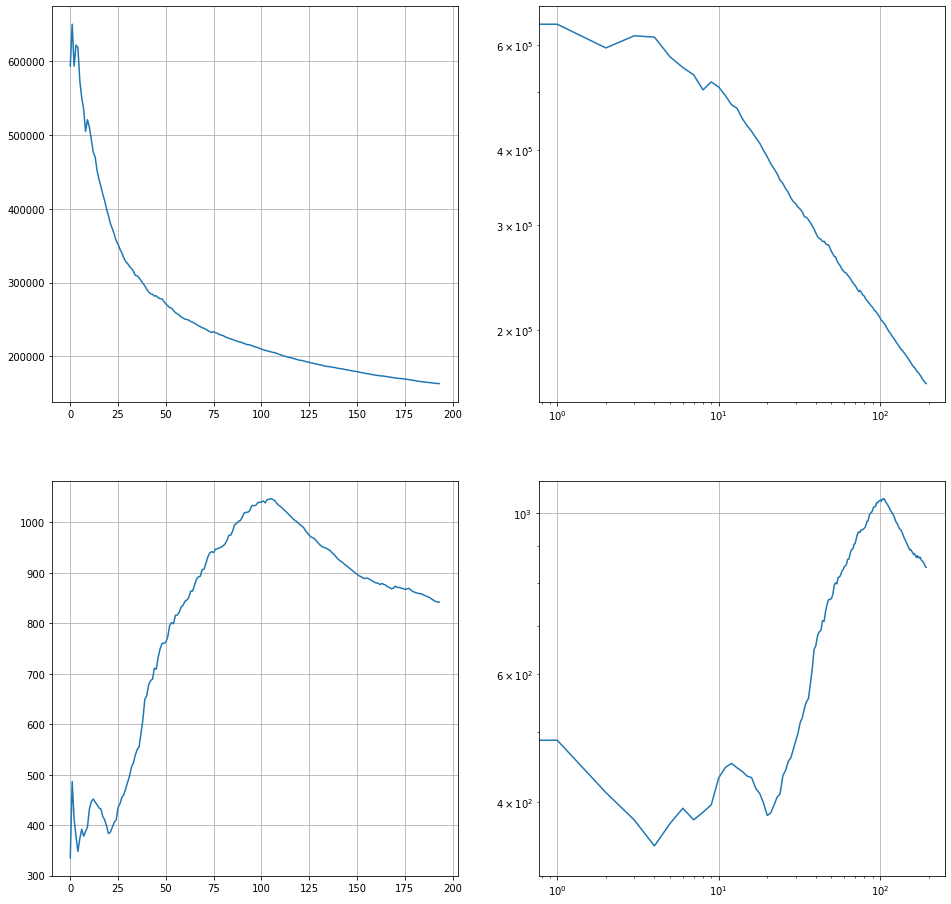

In [284]:
from matplotlib import pyplot as plt
import numpy as np
plt.figure(1,figsize=(16,16))
plt.subplot(221)
plt.plot(np.arange(len(loss_graph)),loss_graph)
plt.grid()
plt.subplot(222)
plt.plot(np.arange(len(loss_graph)),loss_graph)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.subplot(223)
plt.plot(np.arange(len(loss_style_list)),loss_style_list)
plt.grid()
plt.subplot(224)
plt.plot(np.arange(len(loss_style_list)),loss_style_list)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()